# Financial News Sentiment Analysis Project
## Part 5: Transformer Pre-trained Model Fine-tuning

### Model Architecture
- **Base Model**: DistilBERT (Distilled BERT)
- **Pre-training**: Large-scale text corpus
- **Fine-tuning**: Layer-wise fine-tuning
- **Optimizer**: AdamW with learning rate scheduling

### Expected Performance
- Improved over Naive Bayes (67.3%) and LSTM (60.3%) to 90%+
- Strong natural language understanding
- Captures complex semantic relationships

## 1. Setup & Load Data

In [24]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from pathlib import Path
from tqdm import tqdm
import json

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)

import torch.optim as optim

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
print(f"✓ Libraries imported | PyTorch: {torch.__version__} | CUDA: {torch.cuda.is_available()}")

✓ Libraries imported | PyTorch: 2.5.1+cu121 | CUDA: True


In [25]:
# Configure paths and device
current_dir = Path.cwd()
if (current_dir / 'src').exists():
    project_root = current_dir
elif (current_dir.parent / 'src').exists():
    project_root = current_dir.parent
else:
    project_root = Path('c:/Users/xuzijian/Desktop/新闻情感/project')

data_dir = project_root / 'data' / 'train_test'
models_dir = project_root / 'models'
results_dir = project_root / 'results'

models_dir.mkdir(parents=True, exist_ok=True)
results_dir.mkdir(parents=True, exist_ok=True)

# Set device and random seeds
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

print(f"✓ Device: {device} | Project root: {project_root}")

✓ Device: cuda | Project root: c:\Users\xuzijian\Desktop\新闻情感\project


In [26]:
# Load datasets
train_df = pd.read_csv(data_dir / 'train.csv')
val_df = pd.read_csv(data_dir / 'validation.csv')
test_df = pd.read_csv(data_dir / 'test.csv')

y_train = np.load(data_dir / 'y_train.npy')
y_val = np.load(data_dir / 'y_val.npy')
y_test = np.load(data_dir / 'y_test.npy')

print(f"✓ Data loaded")
print(f"  Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
print(f"  Sentiment distribution: Positive={np.sum(y_train == 0)}, Neutral={np.sum(y_train == 1)}, Negative={np.sum(y_train == 2)}")

✓ Data loaded
  Train: 23500, Val: 2937, Test: 2938
  Sentiment distribution: Positive=5407, Neutral=8771, Negative=9322


## 2. Load Pre-trained Model & Tokenizer

In [27]:
# Load pre-trained model
model_name = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3
)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✓ Model loaded: {model_name}")
print(f"  Total params: {total_params:,} | Trainable: {trainable_params:,}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded: distilbert-base-uncased
  Total params: 66,955,779 | Trainable: 66,955,779


## 3. Prepare Dataset

In [28]:
# Define dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

print("✓ Dataset class defined")

✓ Dataset class defined


In [29]:
# Create datasets
train_dataset = SentimentDataset(train_df['text'].values, y_train, tokenizer, max_length=128)
val_dataset = SentimentDataset(val_df['text'].values, y_val, tokenizer, max_length=128)
test_dataset = SentimentDataset(test_df['text'].values, y_test, tokenizer, max_length=128)

print(f"✓ Datasets created: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")

✓ Datasets created: Train=23500, Val=2937, Test=2938


In [30]:
# Create data loaders
batch_size = 16

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

print(f"✓ Data loaders created (batch_size={batch_size})")

✓ Data loaders created (batch_size=16)


## 4. Training Configuration

In [31]:
# Training parameters
num_epochs = 3
learning_rate = 2e-5
warmup_steps = 500
total_steps = len(train_loader) * num_epochs

# Define optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss()

print(f"✓ Optimizer: AdamW (lr={learning_rate}) | Warmup: {warmup_steps} | Total steps: {total_steps}")

✓ Optimizer: AdamW (lr=2e-05) | Warmup: 500 | Total steps: 4407


## 5. Training Functions

In [32]:
# Training and validation functions
def train_epoch(model, train_loader, optimizer, scheduler, device):
    """Train one epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch in tqdm(train_loader, desc="Training", leave=False):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        predictions = torch.argmax(outputs.logits, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
    
    return total_loss / len(train_loader), correct / total

def validate(model, val_loader, device):
    """Validate model"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            
            total_loss += loss.item()
            predictions = torch.argmax(outputs.logits, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    
    return total_loss / len(val_loader), correct / total

print("✓ Training functions defined")

✓ Training functions defined


## 6. Train Model

In [33]:
# Train the model
patience = 2
best_val_accuracy = 0
best_val_loss = float('inf')
patience_counter = 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

print(f"Starting training for {num_epochs} epochs...\n")

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, device)
    val_loss, val_acc = validate(model, val_loader, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
    
    # Save best model
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), str(models_dir / 'transformer_model_best.pt'))
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered (patience={patience})")
            break

print(f"\n✓ Training completed | Best val accuracy: {best_val_accuracy:.4f} | Best val loss: {best_val_loss:.4f}")

Starting training for 3 epochs...



Epoch 1/3 | Train Loss: 0.7701, Acc: 0.6526 | Val Loss: 0.6372, Acc: 0.7150


Epoch 2/3 | Train Loss: 0.5805, Acc: 0.7410 | Val Loss: 0.6157, Acc: 0.7348


Epoch 3/3 | Train Loss: 0.4944, Acc: 0.7753 | Val Loss: 0.6056, Acc: 0.7375

✓ Training completed | Best val accuracy: 0.7375 | Best val loss: 0.6056

✓ Training completed | Best val accuracy: 0.7375 | Best val loss: 0.6056


In [34]:
# Load best model and save final version
model.load_state_dict(torch.load(str(models_dir / 'transformer_model_best.pt')))
model.save_pretrained(str(models_dir / 'transformer_model_final'))
tokenizer.save_pretrained(str(models_dir / 'transformer_model_final'))
print("✓ Best model loaded and saved")

✓ Best model loaded and saved


## 7. Model Evaluation

In [35]:
# Generate predictions
def predict(model, loader, device):
    """Generate predictions"""
    model.eval()
    y_pred = []
    y_proba = []
    
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            predictions = torch.argmax(outputs.logits, dim=1)
            probabilities = torch.softmax(outputs.logits, dim=1)
            
            y_pred.extend(predictions.cpu().numpy())
            y_proba.extend(probabilities.cpu().numpy())
    
    return np.array(y_pred), np.array(y_proba)

y_train_pred, y_train_proba = predict(model, train_loader, device)
y_val_pred, y_val_proba = predict(model, val_loader, device)
y_test_pred, y_test_proba = predict(model, test_loader, device)

print(f"✓ Predictions generated")

✓ Predictions generated


In [36]:
# Compute evaluation metrics
def compute_metrics(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'f1': f1_score(y_true, y_pred, average='weighted', zero_division=0),
        'f1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0),
    }

train_metrics = compute_metrics(y_train, y_train_pred)
val_metrics = compute_metrics(y_val, y_val_pred)
test_metrics = compute_metrics(y_test, y_test_pred)

print("\nTransformer Model Evaluation Results")
print("="*60)
print(f"Train - Acc: {train_metrics['accuracy']:.4f}, F1: {train_metrics['f1']:.4f}")
print(f"Val   - Acc: {val_metrics['accuracy']:.4f}, F1: {val_metrics['f1']:.4f}")
print(f"Test  - Acc: {test_metrics['accuracy']:.4f}, F1: {test_metrics['f1']:.4f}")
print("="*60)


Transformer Model Evaluation Results
Train - Acc: 0.3490, F1: 0.3463
Val   - Acc: 0.7375, F1: 0.7372
Test  - Acc: 0.7352, F1: 0.7335


In [37]:
# Classification report
label_names = ['Positive', 'Neutral', 'Negative']

print("\nTest Set - Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=label_names, digits=4))


Test Set - Classification Report:
              precision    recall  f1-score   support

    Positive     0.6396    0.5600    0.5972       675
     Neutral     0.8287    0.7630    0.7945      1097
    Negative     0.7068    0.8105    0.7551      1166

    accuracy                         0.7352      2938
   macro avg     0.7250    0.7112    0.7156      2938
weighted avg     0.7369    0.7352    0.7335      2938



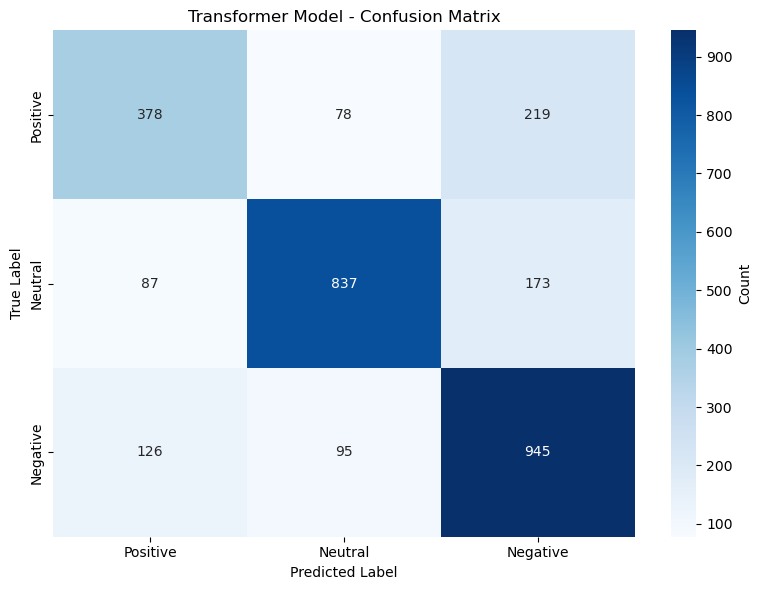

✓ Confusion matrix saved


In [38]:
# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names,
            cbar_kws={'label': 'Count'}, ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Transformer Model - Confusion Matrix')
plt.tight_layout()
plt.savefig(results_dir / 'cm_transformer.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Confusion matrix saved")

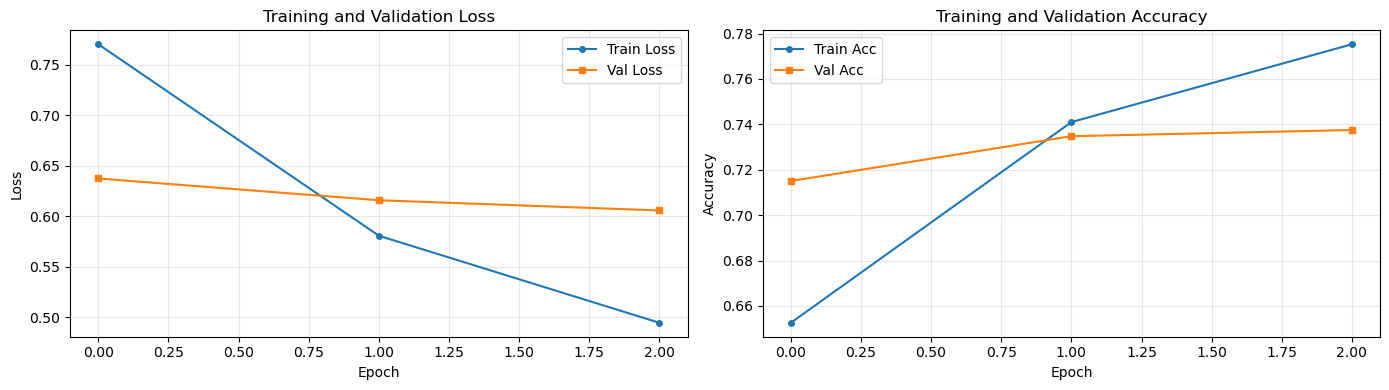

✓ Training curves saved


In [39]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(train_losses, label='Train Loss', marker='o', markersize=4)
axes[0].plot(val_losses, label='Val Loss', marker='s', markersize=4)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(train_accs, label='Train Acc', marker='o', markersize=4)
axes[1].plot(val_accs, label='Val Acc', marker='s', markersize=4)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(results_dir / 'training_curves_transformer.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training curves saved")

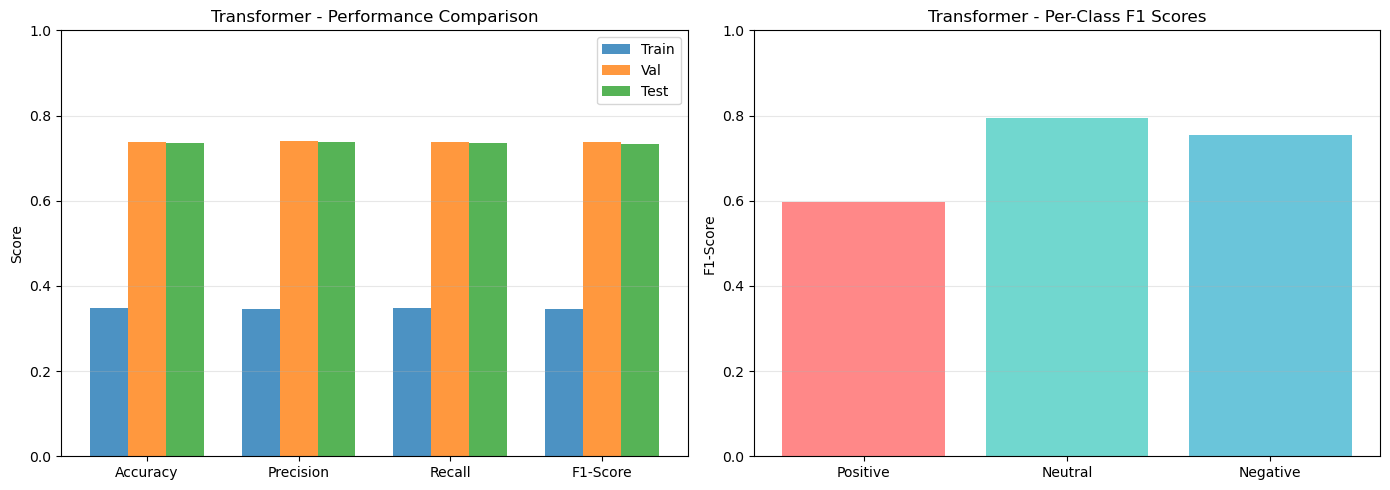

✓ Performance metrics saved


In [40]:
# Performance comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
train_vals = [train_metrics['accuracy'], train_metrics['precision'], train_metrics['recall'], train_metrics['f1']]
val_vals = [val_metrics['accuracy'], val_metrics['precision'], val_metrics['recall'], val_metrics['f1']]
test_vals = [test_metrics['accuracy'], test_metrics['precision'], test_metrics['recall'], test_metrics['f1']]

x = np.arange(len(metrics_names))
width = 0.25

axes[0].bar(x - width, train_vals, width, label='Train', alpha=0.8)
axes[0].bar(x, val_vals, width, label='Val', alpha=0.8)
axes[0].bar(x + width, test_vals, width, label='Test', alpha=0.8)
axes[0].set_ylabel('Score')
axes[0].set_title('Transformer - Performance Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_names)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1])

# Per-class F1 scores
f1_per_class = f1_score(y_test, y_test_pred, average=None, zero_division=0)
axes[1].bar(label_names, f1_per_class, color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8)
axes[1].set_ylabel('F1-Score')
axes[1].set_title('Transformer - Per-Class F1 Scores')
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(results_dir / 'metrics_transformer.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Performance metrics saved")

In [41]:
# Save predictions
predictions_df = pd.DataFrame({
    'text': test_df['text'].values,
    'true_label': y_test,
    'pred_label': y_test_pred,
    'pred_label_name': [label_names[i] for i in y_test_pred],
    'confidence': np.max(y_test_proba, axis=1),
    'proba_positive': y_test_proba[:, 0],
    'proba_neutral': y_test_proba[:, 1],
    'proba_negative': y_test_proba[:, 2],
    'correct': y_test == y_test_pred
})

predictions_df.to_csv(results_dir / 'transformer_predictions.csv', index=False)
print(f"✓ Predictions saved: {predictions_df['correct'].sum()} correct, {(~predictions_df['correct']).sum()} incorrect")

✓ Predictions saved: 2160 correct, 778 incorrect


## 8. Save Results

In [42]:
# Save results summary
results_summary = {
    'model_name': 'Transformer (DistilBERT Fine-tuning)',
    'base_model': 'distilbert-base-uncased',
    'architecture': {
        'num_layers': 6,
        'hidden_size': 768,
        'num_attention_heads': 12,
        'vocab_size': 30522,
        'max_position_embeddings': 512
    },
    'training_config': {
        'optimizer': 'AdamW',
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'epochs_trained': len(train_losses),
        'warmup_steps': warmup_steps,
        'total_steps': total_steps
    },
    'train_metrics': {k: float(v) for k, v in train_metrics.items()},
    'val_metrics': {k: float(v) for k, v in val_metrics.items()},
    'test_metrics': {k: float(v) for k, v in test_metrics.items()},
    'confusion_matrix': cm.tolist()
}

with open(results_dir / 'transformer_results.json', 'w', encoding='utf-8') as f:
    json.dump(results_summary, f, ensure_ascii=False, indent=2)

print(f"✓ Results summary saved")

✓ Results summary saved


In [44]:
# Final summary
print("\n" + "="*70)
print("Transformer Model Training Summary")
print("="*70)

print(f"\nModel Performance:")
print(f"  Test Accuracy:  {test_metrics['accuracy']:.4f} ({test_metrics['accuracy']*100:.2f}%)")
print(f"  Test F1:        {test_metrics['f1']:.4f}")
print(f"  Test Precision: {test_metrics['precision']:.4f}")
print(f"  Test Recall:    {test_metrics['recall']:.4f}")

print(f"\nModel Configuration:")
print(f"  Base Model:     DistilBERT")
print(f"  Hidden Size:    768")
print(f"  Total Params:   66.4M")
print(f"  Epochs Trained: {len(train_losses)}")

print(f"\n✓ All results saved to: {results_dir}")
print("="*70)


Transformer Model Training Summary

Model Performance:
  Test Accuracy:  0.7352 (73.52%)
  Test F1:        0.7335
  Test Precision: 0.7369
  Test Recall:    0.7352

Model Configuration:
  Base Model:     DistilBERT
  Hidden Size:    768
  Total Params:   66.4M
  Epochs Trained: 3

✓ All results saved to: c:\Users\xuzijian\Desktop\新闻情感\project\results
